## Main notebook project MRI - ISPR

In [103]:
# Utility libraries
import os
import random
from datetime import datetime

# Core libraries
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Softmax, Conv2D, MaxPooling2D, Dropout, Flatten, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from keras.utils import np_utils
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from keras.optimizers import Adam
from tensorflow.keras import Input
from skimage.color import rgb2gray

import matplotlib.pyplot as plt # For plotting purposes


# Bug still not solved, resort to old keras module (see below)
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Use the above import when the bug is solved
#import keras
#from keras.callbacks import ModelCheckpoint
#from keras.callbacks import TensorBoard
# ------------------------------------------#

import cv2
import pandas as pd
from tqdm import tqdm

#### get imgs

In [77]:
rmi_files = []
for (root,dirs,files) in os.walk('.\lgg-mri-segmentation\kaggle_3m', topdown=True):
    #print (root)
    #print (dirs)
    for x in files:
        #print ( os.path.join(root, x))
        rmi_files.append(os.path.join(root, x))
    #print ('--------------------------------')        

In [78]:
rmi_files = rmi_files[4:].copy()

In [79]:
imgs = []
masks = []
for i in rmi_files:
    if 'mask' in i:
        masks.append(i)
    else:
        imgs.append(i)
        

In [80]:
df = pd.DataFrame(data={'imgs':imgs, 'masks':masks})
df

imgs  \
0     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
1     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
2     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
3     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
4     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
...                                                 ...   
3924  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   
3925  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   
3926  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   
3927  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   
3928  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   

                                                  masks  
0     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...  
1     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...  
2     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...  
3     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...  
4     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...  
...                                                 ...  
3924  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...  
3925  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...  
3926  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...  
3927  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...  
3928  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...  

[3929 rows x 2 columns]

In [9]:
short = [e[e.rfind('TCGA'):] for e in df["imgs"][df["imgs"].str.contains('19830416')].values]

In [10]:
short[:3]

['TCGA_DU_6399_19830416_1.tif',
 'TCGA_DU_6399_19830416_10.tif',
 'TCGA_DU_6399_19830416_11.tif']

In [11]:
def fun1(x):
    elem1 = int(x[x.rfind('_')+1:x.rfind('.')])
    elem2 = int(x[x.rfind('_', 0, x.rfind('_')-1)+1 : x.rfind('_')])
    return (elem2, elem1)

In [15]:
fun1(short[2])

(19830416, 11)

In [113]:
sorted(short, key = fun1)

['TCGA_DU_6399_19830416_1.tif',
 'TCGA_DU_6399_19830416_2.tif',
 'TCGA_DU_6399_19830416_3.tif',
 'TCGA_DU_6399_19830416_4.tif',
 'TCGA_DU_6399_19830416_5.tif',
 'TCGA_DU_6399_19830416_6.tif',
 'TCGA_DU_6399_19830416_7.tif',
 'TCGA_DU_6399_19830416_8.tif',
 'TCGA_DU_6399_19830416_9.tif',
 'TCGA_DU_6399_19830416_10.tif',
 'TCGA_DU_6399_19830416_11.tif',
 'TCGA_DU_6399_19830416_12.tif',
 'TCGA_DU_6399_19830416_13.tif',
 'TCGA_DU_6399_19830416_14.tif',
 'TCGA_DU_6399_19830416_15.tif',
 'TCGA_DU_6399_19830416_16.tif',
 'TCGA_DU_6399_19830416_17.tif',
 'TCGA_DU_6399_19830416_18.tif',
 'TCGA_DU_6399_19830416_19.tif',
 'TCGA_DU_6399_19830416_20.tif',
 'TCGA_DU_6399_19830416_21.tif',
 'TCGA_DU_6399_19830416_22.tif',
 'TCGA_DU_6399_19830416_23.tif',
 'TCGA_DU_6399_19830416_24.tif',
 'TCGA_DU_6399_19830416_25.tif',
 'TCGA_DU_6399_19830416_26.tif',
 'TCGA_DU_6399_19830416_27.tif',
 'TCGA_DU_6399_19830416_28.tif',
 'TCGA_DU_6399_19830416_29.tif',
 'TCGA_DU_6399_19830416_30.tif',
 'TCGA_DU_6399_1983

In [115]:
sorted(df["imgs"].values, key=fun1)[:100]

['.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_1.tif',
 '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_2.tif',
 '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_3.tif',
 '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_4.tif',
 '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_5.tif',
 '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_6.tif',
 '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_7.tif',
 '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_8.tif',
 '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_9.tif',
 '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_10.tif',
 '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_11.tif

In [12]:
df['imgs'] = sorted(df["imgs"].values, key=fun1).copy()

In [13]:
df.masks.values

array(['.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10_mask.tif',
       '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11_mask.tif',
       '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12_mask.tif',
       ...,
       '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_HT_A61B_19991127\\TCGA_HT_A61B_19991127_88_mask.tif',
       '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_HT_A61B_19991127\\TCGA_HT_A61B_19991127_8_mask.tif',
       '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_HT_A61B_19991127\\TCGA_HT_A61B_19991127_9_mask.tif'],
      dtype=object)

In [14]:
df.masks.values[0]

'.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10_mask.tif'

In [81]:
x = df.masks.values[0]
int(x[x.rfind('_', 0, x.rfind('_')-1)+1 : x.rfind('_')])

10

In [84]:
int(x[x.rfind('_', 0, x.rfind('_', 0, x.rfind('_')-1)-1)+1 : x.rfind('_')])

1996090910

In [91]:
int(x[x.rfind('_',0,x.rfind('_')-1)+1:x.rfind('_')])

10

In [81]:
def fun2(x):
    elem1 = int(x[x.rfind('_',0,x.rfind('_')-1)+1:x.rfind('_')])
    elem2 = int(x[x.rfind('_', 0, x.rfind('_', 0, x.rfind('_')-1)-1)+1 : x.rfind('_', 0, x.rfind('_')-1)])
    return (elem2, elem1)

In [20]:
x = df.masks.values[0]
fun2(x)

(19960909, 10)

In [16]:
df['masks'] = sorted(df["masks"].values, key=fun2).copy()

In [132]:
df.values[:100]

array([['.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_1.tif',
        '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_1_mask.tif'],
       ['.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_2.tif',
        '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_2_mask.tif'],
       ['.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_3.tif',
        '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_3_mask.tif'],
       ['.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_4.tif',
        '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_4_mask.tif'],
       ['.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_5.tif',
        '.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_DU_6399_19830416\\TCGA_DU_6399_19830416_5_ma

In [143]:
[ e[e.find('_',e.find('TCGA'))+1 : e.find('_',e.find('_',e.find('TCGA'))+1)] for e in df.imgs]

['DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',
 'DU',

In [144]:
e = df.imgs[0]
e[e.find('_',e.find('TCGA'))+1 : e.find('_',e.find('_',e.find('TCGA'))+1)]

'DU'

In [151]:
e = df.imgs[0]
e[e.find('_',e.find('_',e.find('TCGA'))+1)+1 : e.find('_', e.find('_',e.find('_',e.find('TCGA'))+1)+1)]

'6399'

In [163]:
e = df.imgs[0]
e[e.find('_', e.find('_',e.find('_',e.find('TCGA'))+1)+1)+1 : e.find('\\', e.find('_', e.find('_',e.find('_',e.find('TCGA'))+1)+1)+1)]

'19830416'

In [82]:
df['ic_img'] = [ e[e.find('_',e.find('TCGA'))+1 : e.find('_',e.find('_',e.find('TCGA'))+1)] for e in df.imgs]
df['ic_mask'] = [ e[e.find('_',e.find('TCGA'))+1 : e.find('_',e.find('_',e.find('TCGA'))+1)] for e in df.masks]

In [83]:
df['pid_img'] = [ e[e.find('_',e.find('_',e.find('TCGA'))+1)+1 : e.find('_', e.find('_',e.find('_',e.find('TCGA'))+1)+1)] for e in df.imgs]
df['pid_mask'] = [ e[e.find('_',e.find('_',e.find('TCGA'))+1)+1 : e.find('_', e.find('_',e.find('_',e.find('TCGA'))+1)+1)] for e in df.masks]

In [84]:
df['snum_img'] = [ e[e.find('_', e.find('_',e.find('_',e.find('TCGA'))+1)+1)+1 : e.find('\\', e.find('_', e.find('_',e.find('_',e.find('TCGA'))+1)+1)+1)] for e in df.imgs]
df['snum_mask'] = [ e[e.find('_', e.find('_',e.find('_',e.find('TCGA'))+1)+1)+1 : e.find('\\', e.find('_', e.find('_',e.find('_',e.find('TCGA'))+1)+1)+1)] for e in df.masks]

In [85]:
df

imgs  \
0     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
1     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
2     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
3     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
4     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
...                                                 ...   
3924  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   
3925  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   
3926  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   
3927  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   
3928  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   

                                                  masks ic_img ic_mask  \
0     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...     CS      CS   
1     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...     CS      CS   
2     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...     CS      CS   
3     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...     CS      CS   
4     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...     CS      CS   
...                                                 ...    ...     ...   
3924  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...     HT      HT   
3925  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...     HT      HT   
3926  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...     HT      HT   
3927  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...     HT      HT   
3928  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...     HT      HT   

     pid_img pid_mask  snum_img snum_mask  
0       4941     4941  19960909  19960909  
1       4941     4941  19960909  19960909  
2       4941     4941  19960909  19960909  
3       4941     4941  19960909  19960909  
4       4941     4941  19960909  19960909  
...      ...      ...       ...       ...  
3924    A61B     A61B  19991127  19991127  
3925    A61B     A61B  19991127  19991127  
3926    A61B     A61B  19991127  19991127  
3927    A61B     A61B  19991127  19991127  
3928    A61B     A61B  19991127  19991127  

[3929 rows x 8 columns]

In [86]:
print(np.all(df.ic_img == df.ic_mask),
np.all(df.pid_img == df.pid_mask),
np.all(df.snum_img == df.snum_mask))

True True True


In [87]:
df.drop(['ic_mask','pid_mask','snum_mask'],axis=1, inplace=True)
df.rename({'imgs':'img','masks':'msk','ic_img':'insti_code', 'pid_img':'pid', 'snum_img':'slice_num'}, axis=1, inplace=True)

In [88]:
# Check whether mask is present or not
def check_mask(mask_path):
    img = cv2.imread(mask_path)
    max_val = img.max()
    if max_val > 0:
        return 1
    else:
        return 0

In [89]:
df['msk_present'] = df.msk.apply(lambda x: check_mask(x))

In [90]:
df['msk_present'].value_counts()

0    2556
1    1373
Name: msk_present, dtype: int64

In [91]:
#final df
df

img  \
0     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
1     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
2     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
3     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
4     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...   
...                                                 ...   
3924  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   
3925  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   
3926  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   
3927  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   
3928  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   

                                                    msk insti_code   pid  \
0     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...         CS  4941   
1     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...         CS  4941   
2     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...         CS  4941   
3     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...         CS  4941   
4     .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_...         CS  4941   
...                                                 ...        ...   ...   
3924  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...         HT  A61B   
3925  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...         HT  A61B   
3926  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...         HT  A61B   
3927  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...         HT  A61B   
3928  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...         HT  A61B   

     slice_num  msk_present  
0     19960909            0  
1     19960909            1  
2     19960909            1  
3     19960909            1  
4     19960909            1  
...        ...          ...  
3924  19991127            0  
3925  19991127            0  
3926  19991127            0  
3927  19991127            0  
3928  19991127            0  

[3929 rows x 6 columns]

#### let's check all slices and masks for a certain patient

In [27]:
from cv2 import imread

In [239]:
df[df.msk_present==1]

img  \
12    .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_6399_...   
13    .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_6399_...   
14    .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_6399_...   
15    .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_6399_...   
16    .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_6399_...   
...                                                 ...   
3909  .\lgg-mri-segmentation\kaggle_3m\TCGA_FG_A60K_...   
3910  .\lgg-mri-segmentation\kaggle_3m\TCGA_FG_A60K_...   
3911  .\lgg-mri-segmentation\kaggle_3m\TCGA_FG_A60K_...   
3912  .\lgg-mri-segmentation\kaggle_3m\TCGA_FG_A60K_...   
3913  .\lgg-mri-segmentation\kaggle_3m\TCGA_FG_A60K_...   

                                                    msk insti_code   pid  \
12    .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_6399_...         DU  6399   
13    .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_6399_...         DU  6399   
14    .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_6399_...         DU  6399   
15    .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_6399_...         DU  6399   
16    .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_6399_...         DU  6399   
...                                                 ...        ...   ...   
3909  .\lgg-mri-segmentation\kaggle_3m\TCGA_FG_A60K_...         FG  A60K   
3910  .\lgg-mri-segmentation\kaggle_3m\TCGA_FG_A60K_...         FG  A60K   
3911  .\lgg-mri-segmentation\kaggle_3m\TCGA_FG_A60K_...         FG  A60K   
3912  .\lgg-mri-segmentation\kaggle_3m\TCGA_FG_A60K_...         FG  A60K   
3913  .\lgg-mri-segmentation\kaggle_3m\TCGA_FG_A60K_...         FG  A60K   

     slice_num  msk_present  
12    19830416            1  
13    19830416            1  
14    19830416            1  
15    19830416            1  
16    19830416            1  
...        ...          ...  
3909  20040224            1  
3910  20040224            1  
3911  20040224            1  
3912  20040224            1  
3913  20040224            1  

[1373 rows x 6 columns]

In [59]:
x = cv2.imread(df.img[12], cv2.IMREAD_COLOR)
x.shape

(256, 256, 3)

In [60]:
x = cv2.imread(df.msk[12], cv2.IMREAD_GRAYSCALE)
x.shape

(256, 256)

In [36]:
x.shape

(256, 256, 3)

In [47]:
img = cv2.imread(df.img[18])
img2 = cv2.imread(df.img[18])
msk = cv2.imread(df.msk[18])
img2[msk==255] = 255

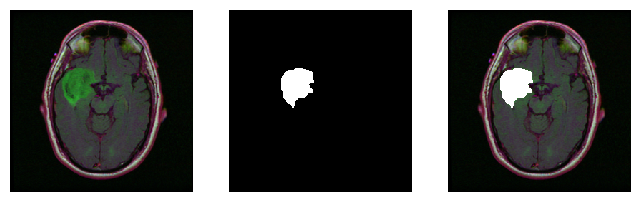

In [29]:
fig, axs = plt.subplots(1,3, figsize=(8,4))
axs[0].imshow(img)
axs[0].axis('off') 
axs[1].imshow(msk)
axs[1].axis('off') 
axs[2].imshow(img2)
axs[2].axis('off') 
plt.show()

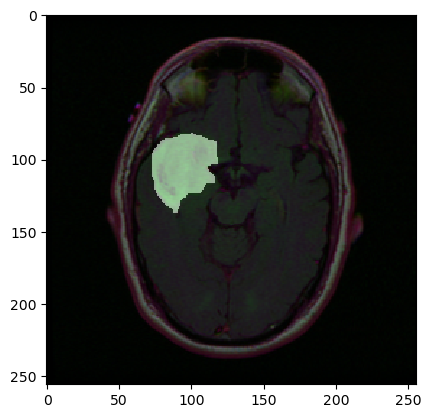

In [305]:
plt.imshow(img)
plt.imshow(msk, alpha=0.5)

In [62]:
x.shape

(256, 256)

In [77]:
np.expand_dims(x, axis=(0,-1)).shape

(1, 256, 256, 1)

### load images in memory

In [30]:
df.msk_present.value_counts()/len(df)

0    0.650547
1    0.349453
Name: msk_present, dtype: float64

In [98]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=2)
# validation split
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=2)
print("Train shape: {}\nTest shape: {}\nValidation shape: {}".format(df_train.shape, df_test.shape, df_val.shape))

Train shape: (2828, 6)
Test shape: (393, 6)
Validation shape: (708, 6)


In [99]:
df_val.msk_present.value_counts()/len(df_val)

0    0.644068
1    0.355932
Name: msk_present, dtype: float64

In [36]:
#from matplotlib.image import imread

# Let's load all train images and put them into the right format
#train_path = os.path.abspath('membrane/train/image')
#train_y_path = os.path.abspath('membrane/train/label')

#test_path = os.path.abspath('membrane/test/')

def build_dataset(temp_df, y_path=None):
    
    x_data = None
    y_data = None

    for image_file_index in tqdm(temp_df.index):

        x = cv2.imread(temp_df.img[image_file_index], cv2.IMREAD_COLOR)

        if y_path is not None:
            y = cv2.imread(temp_df.msk[image_file_index], cv2.IMREAD_GRAYSCALE)

        if x_data is None:
            x_data = np.expand_dims(x, axis=(0))  # add batch and channel dimensions
            if y_path is not None:
                y_data = np.expand_dims(y, axis=(0,-1))  # add batch dimension, we do not need a channel
        else:
            x_data = np.concatenate((x_data, np.expand_dims(x, axis=(0))), axis=0)
            if y_path is not None:
                y_data = np.concatenate((y_data, np.expand_dims(y, axis=(0,-1))), axis=0)
    
    x_data = x_data.astype("float32")
    if y_path is not None:
        y_data = y_data.astype('float32')
        y_data = y_data/255.  #mask in binary 0-255; converting to 0-1
    
    return x_data, y_data

In [37]:
%%time
x_train, y_train = build_dataset(df_train, 'yes')
x_val, y_val = build_dataset(df_val, 'yes')
x_test, y_test = build_dataset(df_test, 'yes')


print(f'Final shape of train dataset is: x -> {x_train.shape} and y -> {y_train.shape}')
print(f'Final shape of val dataset is: x -> {x_val.shape} and y -> {y_val.shape}')
print(f'Final shape of test dataset is: x -> {x_test.shape} and y -> {y_test.shape}')
#print(f'Final shape of test dataset is: x -> {x_test.shape}')

100%|████████████████████████████████████████████████████████████████████████████████| 393/393 [00:12<00:00, 32.18it/s]


Final shape of train dataset is: x -> (2828, 256, 256, 3) and y -> (2828, 256, 256, 1)
Final shape of val dataset is: x -> (708, 256, 256, 3) and y -> (708, 256, 256, 1)
Final shape of test dataset is: x -> (393, 256, 256, 3) and y -> (393, 256, 256, 1)
Wall time: 7min 3s


##### testing data load

In [38]:
print(x_train.shape)
print(y_train.shape)

(2828, 256, 256, 3)
(2828, 256, 256, 1)


In [59]:
df_train

img  \
3246  .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_5397_...   
2761  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A5RC_...   
1407  .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_5853_...   
2127  .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_A5TP_...   
161   .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_7008_...   
...                                                 ...   
2571  .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_5395_...   
583   .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_7014_...   
1319  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_7686_...   
2365  .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_A5TU_...   
2801  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...   

                                                    msk insti_code   pid  \
3246  .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_5397_...         CS  5397   
2761  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A5RC_...         HT  A5RC   
1407  .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_5853_...         DU  5853   
2127  .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_A5TP_...         DU  A5TP   
161   .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_7008_...         DU  7008   
...                                                 ...        ...   ...   
2571  .\lgg-mri-segmentation\kaggle_3m\TCGA_CS_5395_...         CS  5395   
583   .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_7014_...         DU  7014   
1319  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_7686_...         HT  7686   
2365  .\lgg-mri-segmentation\kaggle_3m\TCGA_DU_A5TU_...         DU  A5TU   
2801  .\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_...         HT  A61B   

     slice_num  msk_present  
3246  20010315            0  
2761  19990831            0  
1407  19950823            0  
2127  19970614            0  
161   19830723            0  
...        ...          ...  
2571  19981004            0  
583   19860618            1  
1319  19950629            1  
2365  19980312            0  
2801  19991127            0  

[2828 rows x 6 columns]

In [72]:
cv2.imread(df_train.img[583], cv2.IMREAD_COLOR)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

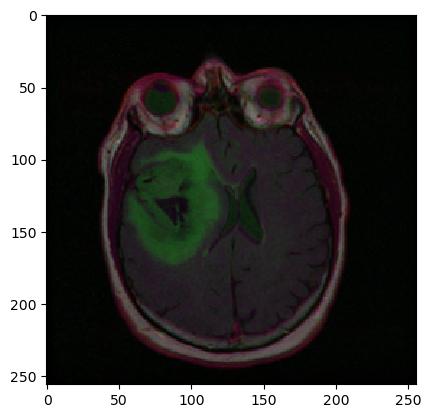

In [73]:
plt.imshow(cv2.imread(df_train.img[583], cv2.IMREAD_COLOR))

In [71]:
x_train[583,:,:,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

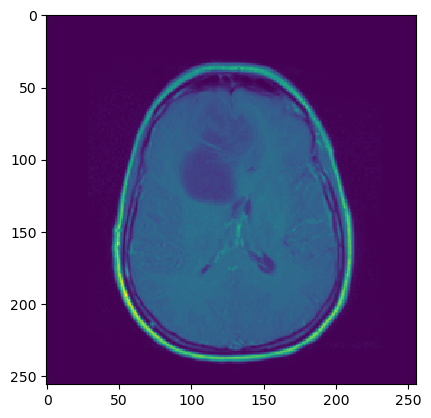

In [64]:
plt.imshow(x_train[583,:,:,0])

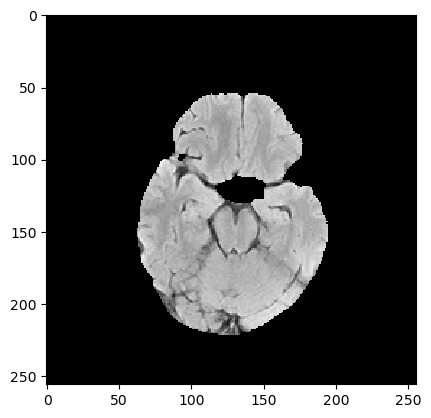

In [233]:
plt.imshow(x_train[2,:,:,1], cmap='gray')

In [228]:
x = cv2.imread(df.img[12], cv2.IMREAD_COLOR)

In [415]:
np.reshape(y_train[0], (256,256))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

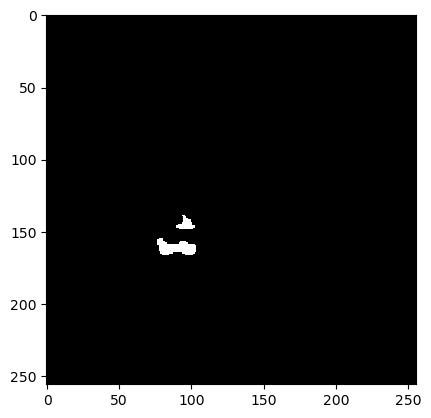

In [416]:
plt.imshow(np.reshape(y_train[300], (256,256)), cmap='gray')


In [417]:
x_val.shape

(708, 256, 256, 3)

In [418]:
y_val.shape

(708, 256, 256, 1)

##### save numpy arrays

### data pre-processing steps
- global standardization OR Normalization + centering
- oversampling

In [48]:
#load skull stripped data
with open('data_preprocessed_v2.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f)
    x_val = np.load(f)
    y_val = np.load(f)
    x_test = np.load(f)
    y_test = np.load(f)    

In [30]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(2664, 256, 256, 3)
(2664, 256, 256, 1)
(659, 256, 256, 3)
(659, 256, 256, 1)
(367, 256, 256, 3)
(367, 256, 256, 1)


In [215]:
x_train_o = x_train.copy()
x_val_o = x_val.copy()
x_test_o = x_test.copy()

#### resizing (optional)

#### normalization + centering

#### global standardization

In [7]:
#global standardization 
mean = np.mean(x_train)
std = np.std(x_train)
x_train-= mean
x_train /= std

x_val -= mean  #using training mean and std also for val data standardization
x_val /= std

x_test -= mean  #using training mean and std also for test data standardization
x_test /= std

#### oversampling

In [49]:
#oversampling functions
from skimage.transform import rescale
from skimage.transform import rotate

image_rows = 256
image_cols = 256

def oversample(images, masks):

    images_o = []
    masks_o = []
    for i in tqdm(range(len(masks))):
        images_o.append(images[i])
        masks_o.append(masks[i])
        
        if np.max(masks[i]) < 1:
            continue
            
        image_a, mask_a = augmentation_rotate(images[i], masks[i])
        images_o.append(image_a)
        masks_o.append(mask_a)
        image_a, mask_a = augmentation_scale(images[i], masks[i])
        images_o.append(image_a)
        masks_o.append(mask_a)


    images_o = np.array(images_o)
    masks_o = np.array(masks_o)

    return (images_o, masks_o)


def augmentation_rotate(img, img_mask):
    angle = np.random.uniform(9.0, 18.0) * -1
    scale = 1.0 + np.random.uniform(0.02, 0.08) * -1

    img = rotate(img, angle, resize=False, order=3, preserve_range=True)
    img = rescale(img, scale, order=3, preserve_range=True)
    
    img_mask = rotate(img_mask, angle, resize=False, order=0, preserve_range=True)
    img_mask = rescale(img_mask, scale, order=0, preserve_range=True)
    
    if scale > 1:
        img = center_crop(img, image_rows, image_cols)
        img_mask = center_crop(img_mask, image_rows, image_cols)
    else:
        img = zeros_pad(img, image_rows)
        img_mask = zeros_pad(img_mask, image_rows)

    return img, img_mask


def augmentation_scale(img, img_mask):
    angle = np.random.uniform(9.0, 18.0) * 1
    scale = 1.0 + np.random.uniform(0.02, 0.08) * 1

    img = rotate(img, angle, resize=False, order=3, preserve_range=True)
    img = rescale(img, scale, order=3, preserve_range=True)
    
    img_mask = rotate(img_mask, angle, resize=False, order=0, preserve_range=True)
    img_mask = rescale(img_mask, scale, order=0, preserve_range=True)
    
    if scale > 1:
        img = center_crop(img, image_rows, image_cols)
        img_mask = center_crop(img_mask, image_rows, image_cols)
    else:
        img = zeros_pad(img, image_rows)
        img_mask = zeros_pad(img_mask, image_rows)

    return img, img_mask

def center_crop(img, cropx, cropy):
    startx = img.shape[1] // 2 - (cropx // 2)
    starty = img.shape[0] // 2 - (cropy // 2)
    return img[starty : starty + cropy, startx : startx + cropx]


def zeros_pad(img, size):
    pad_before = int(round(((size - img.shape[0]) / 2.0)))
    pad_after = size - img.shape[0] - pad_before
    if len(img.shape) > 2:
        return np.pad(
            img,
            ((pad_before, pad_after), (pad_before, pad_after), (0, 0)),
            mode="constant",
        )
    return np.pad(img, (pad_before, pad_after), mode="constant")

##### testing oversampling

In [218]:
ct = 0
for e in y_train:
    if np.max(e)<1:
        ct += 1
        
print(len(y_train))
print(ct)
print('ratio of abnormal vs normal imgs: %', round(ct/len(y_train),2))

2828
1840
ratio of abnormal vs normal imgs: % 0.65


In [219]:
temp_x, temp_y = oversample(x_train[:20].copy(), y_train[:20].copy())

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 22.65it/s]


In [220]:
print(temp_x.shape)
print(temp_y.shape)

(30, 256, 256, 3)
(30, 256, 256, 1)


In [221]:
ct = 0
for e in temp_y:
    if np.max(e)<1:
        ct += 1
        
print(len(temp_y))
print(ct)
print('ratio of abnormal vs normal imgs: %', round(ct/len(temp_y),2))

30
15
ratio of abnormal vs normal imgs: % 0.5


In [222]:
ct = 0
for n, e in enumerate(y_train):
    if np.max(e)>=1:
        ct += 1
        if ct == 1: 
            print(n)
            break

5


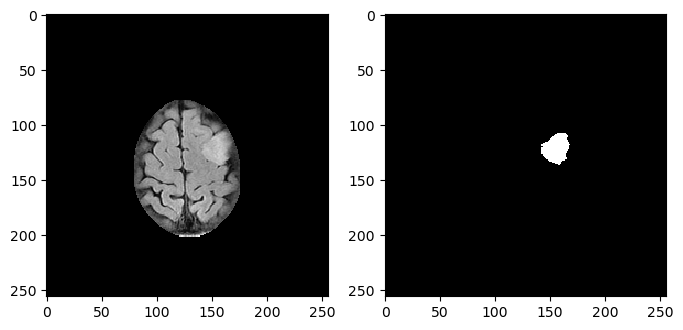

In [223]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(x_train[5,:,:,1], cmap='gray')
axs[1].imshow(np.reshape(y_train[5], (256,256)), cmap='gray')

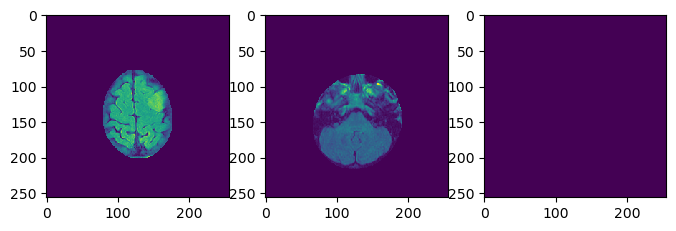

In [225]:
fig, axs = plt.subplots(1,3, figsize=(8,4))
axs[0].imshow(x_train[5,:,:,1])
axs[1].imshow(x_train[6,:,:,1])
axs[2].imshow(x_train[7,:,:,1])

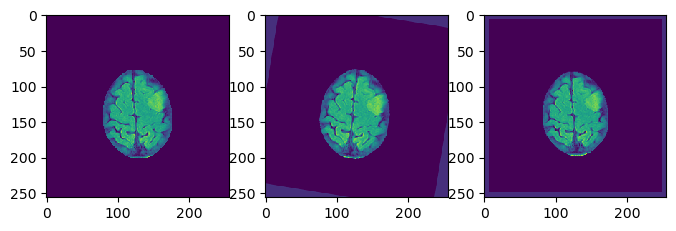

In [226]:
fig, axs = plt.subplots(1,3, figsize=(8,4))
axs[0].imshow(temp_x[5,:,:,1])
axs[1].imshow(temp_x[6,:,:,1])
axs[2].imshow(temp_x[7,:,:,1])

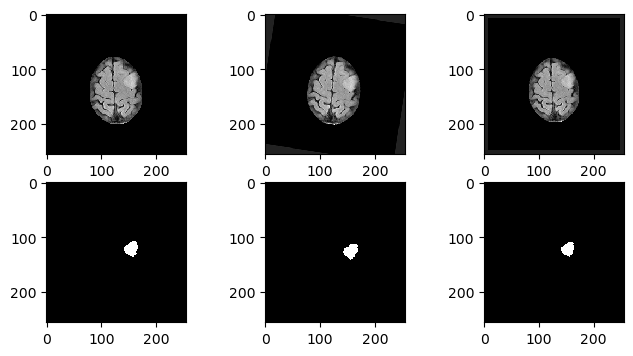

In [227]:
fig, axs = plt.subplots(2,3, figsize=(8,4))
axs[0,0].imshow(temp_x[5,:,:,1], cmap='gray'), 
axs[0,1].imshow(temp_x[6,:,:,1], cmap='gray')
axs[0,2].imshow(temp_x[7,:,:,1], cmap='gray')
axs[1,0].imshow(np.reshape(temp_y[5], (256,256)), cmap='gray')
axs[1,1].imshow(np.reshape(temp_y[6], (256,256)), cmap='gray')
axs[1,2].imshow(np.reshape(temp_y[7], (256,256)), cmap='gray')
plt.show()

##### oversampling training set

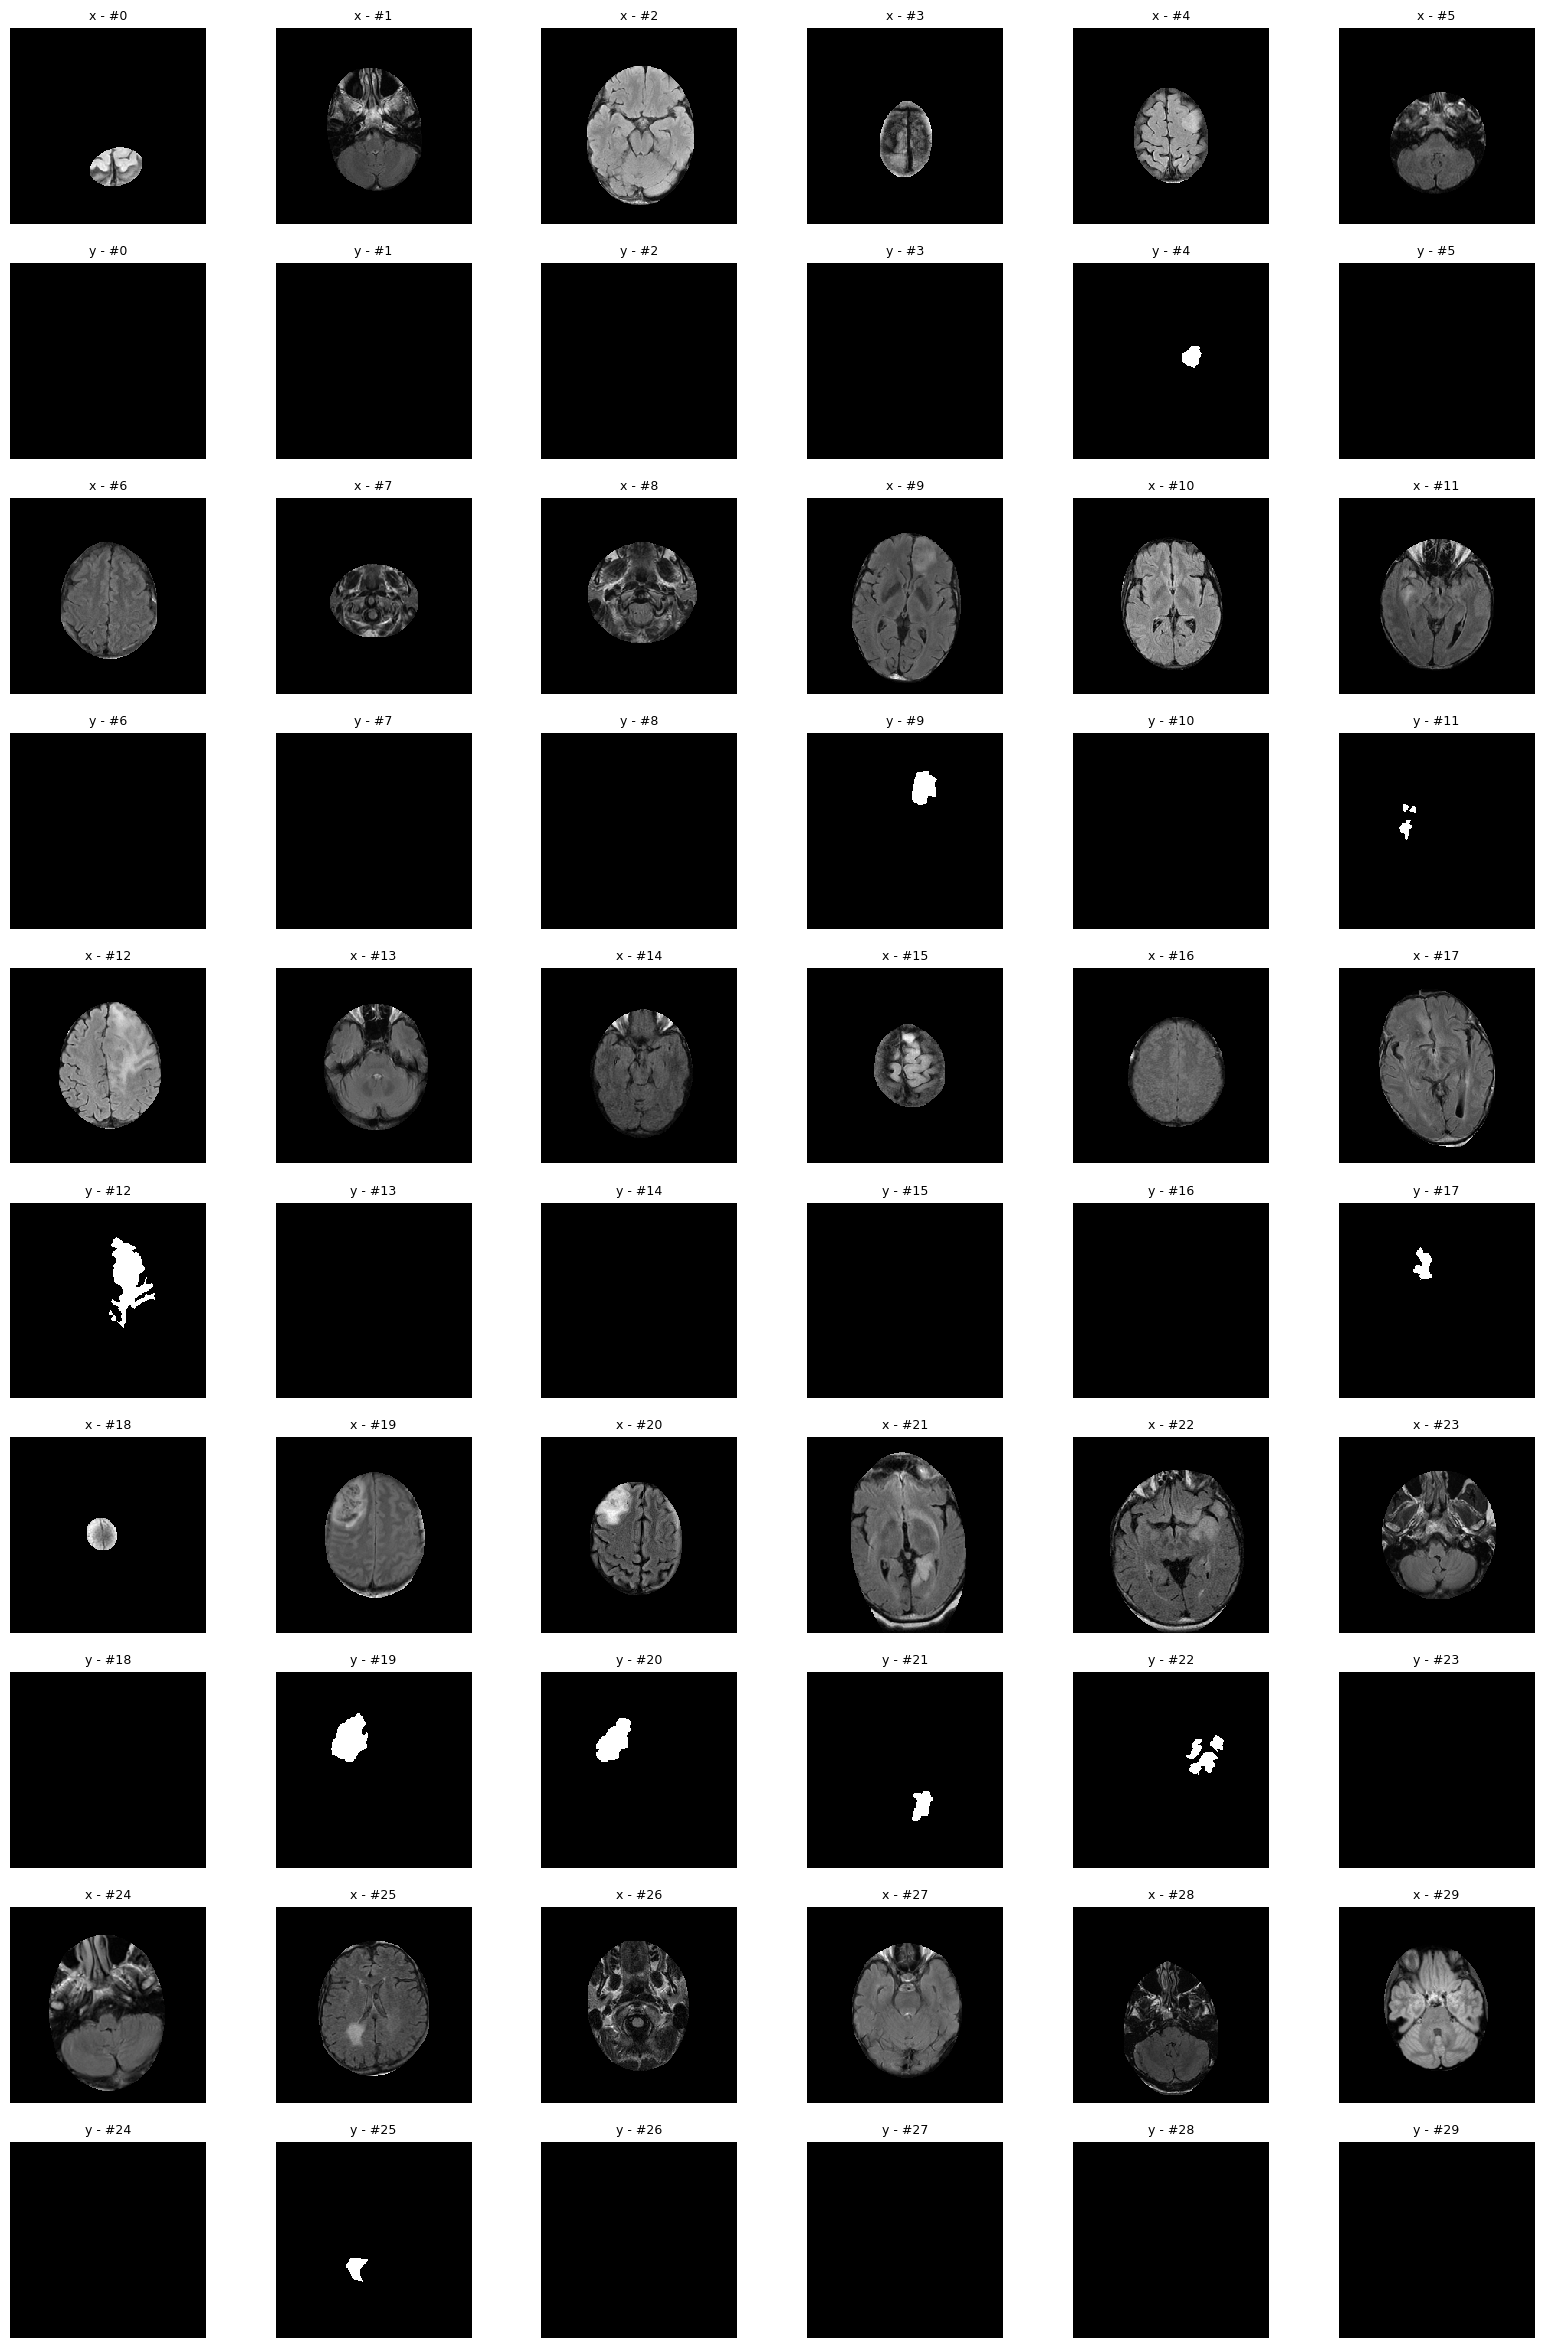

In [41]:
nrep = 5
nrow = 6
fig, axs = plt.subplots(2*nrep,nrow,figsize=(20,6*nrep))
for i in range(nrep):
    for _ in range(nrow): axs[0+2*i,_].imshow(x_train[(_+nrow*i),:,:,1], cmap='gray'), axs[0+2*i,_].axis('off'), axs[0+2*i,_].set_title(f'x - #{(_+nrow*i)}', fontsize=9)
    for _ in range(nrow): axs[1+2*i,_].imshow(y_train[(_+nrow*i),:,:,0], cmap='gray'), axs[1+2*i,_].axis('off'), axs[1+2*i,_].set_title(f'y - #{(_+nrow*i)}',fontsize=9)  
    

In [55]:
# oversampling training set
x_train, y_train = oversample(x_train, y_train)  #oversampling training set

100%|██████████████████████████████████████████████████████████████████████████████| 2664/2664 [06:57<00:00,  6.38it/s]


In [56]:
print(x_train.shape)
print(y_train.shape)

(4634, 256, 256, 3)
(4634, 256, 256, 1)


In [57]:
ct = 0
for e in y_train:
    if np.max(e)>=1:
        ct += 1
        
print(len(y_train))
print(ct)
print('ratio of abnormal vs normal imgs: %', round(ct/len(y_train),2))

4634
2955
ratio of abnormal vs normal imgs: % 0.64


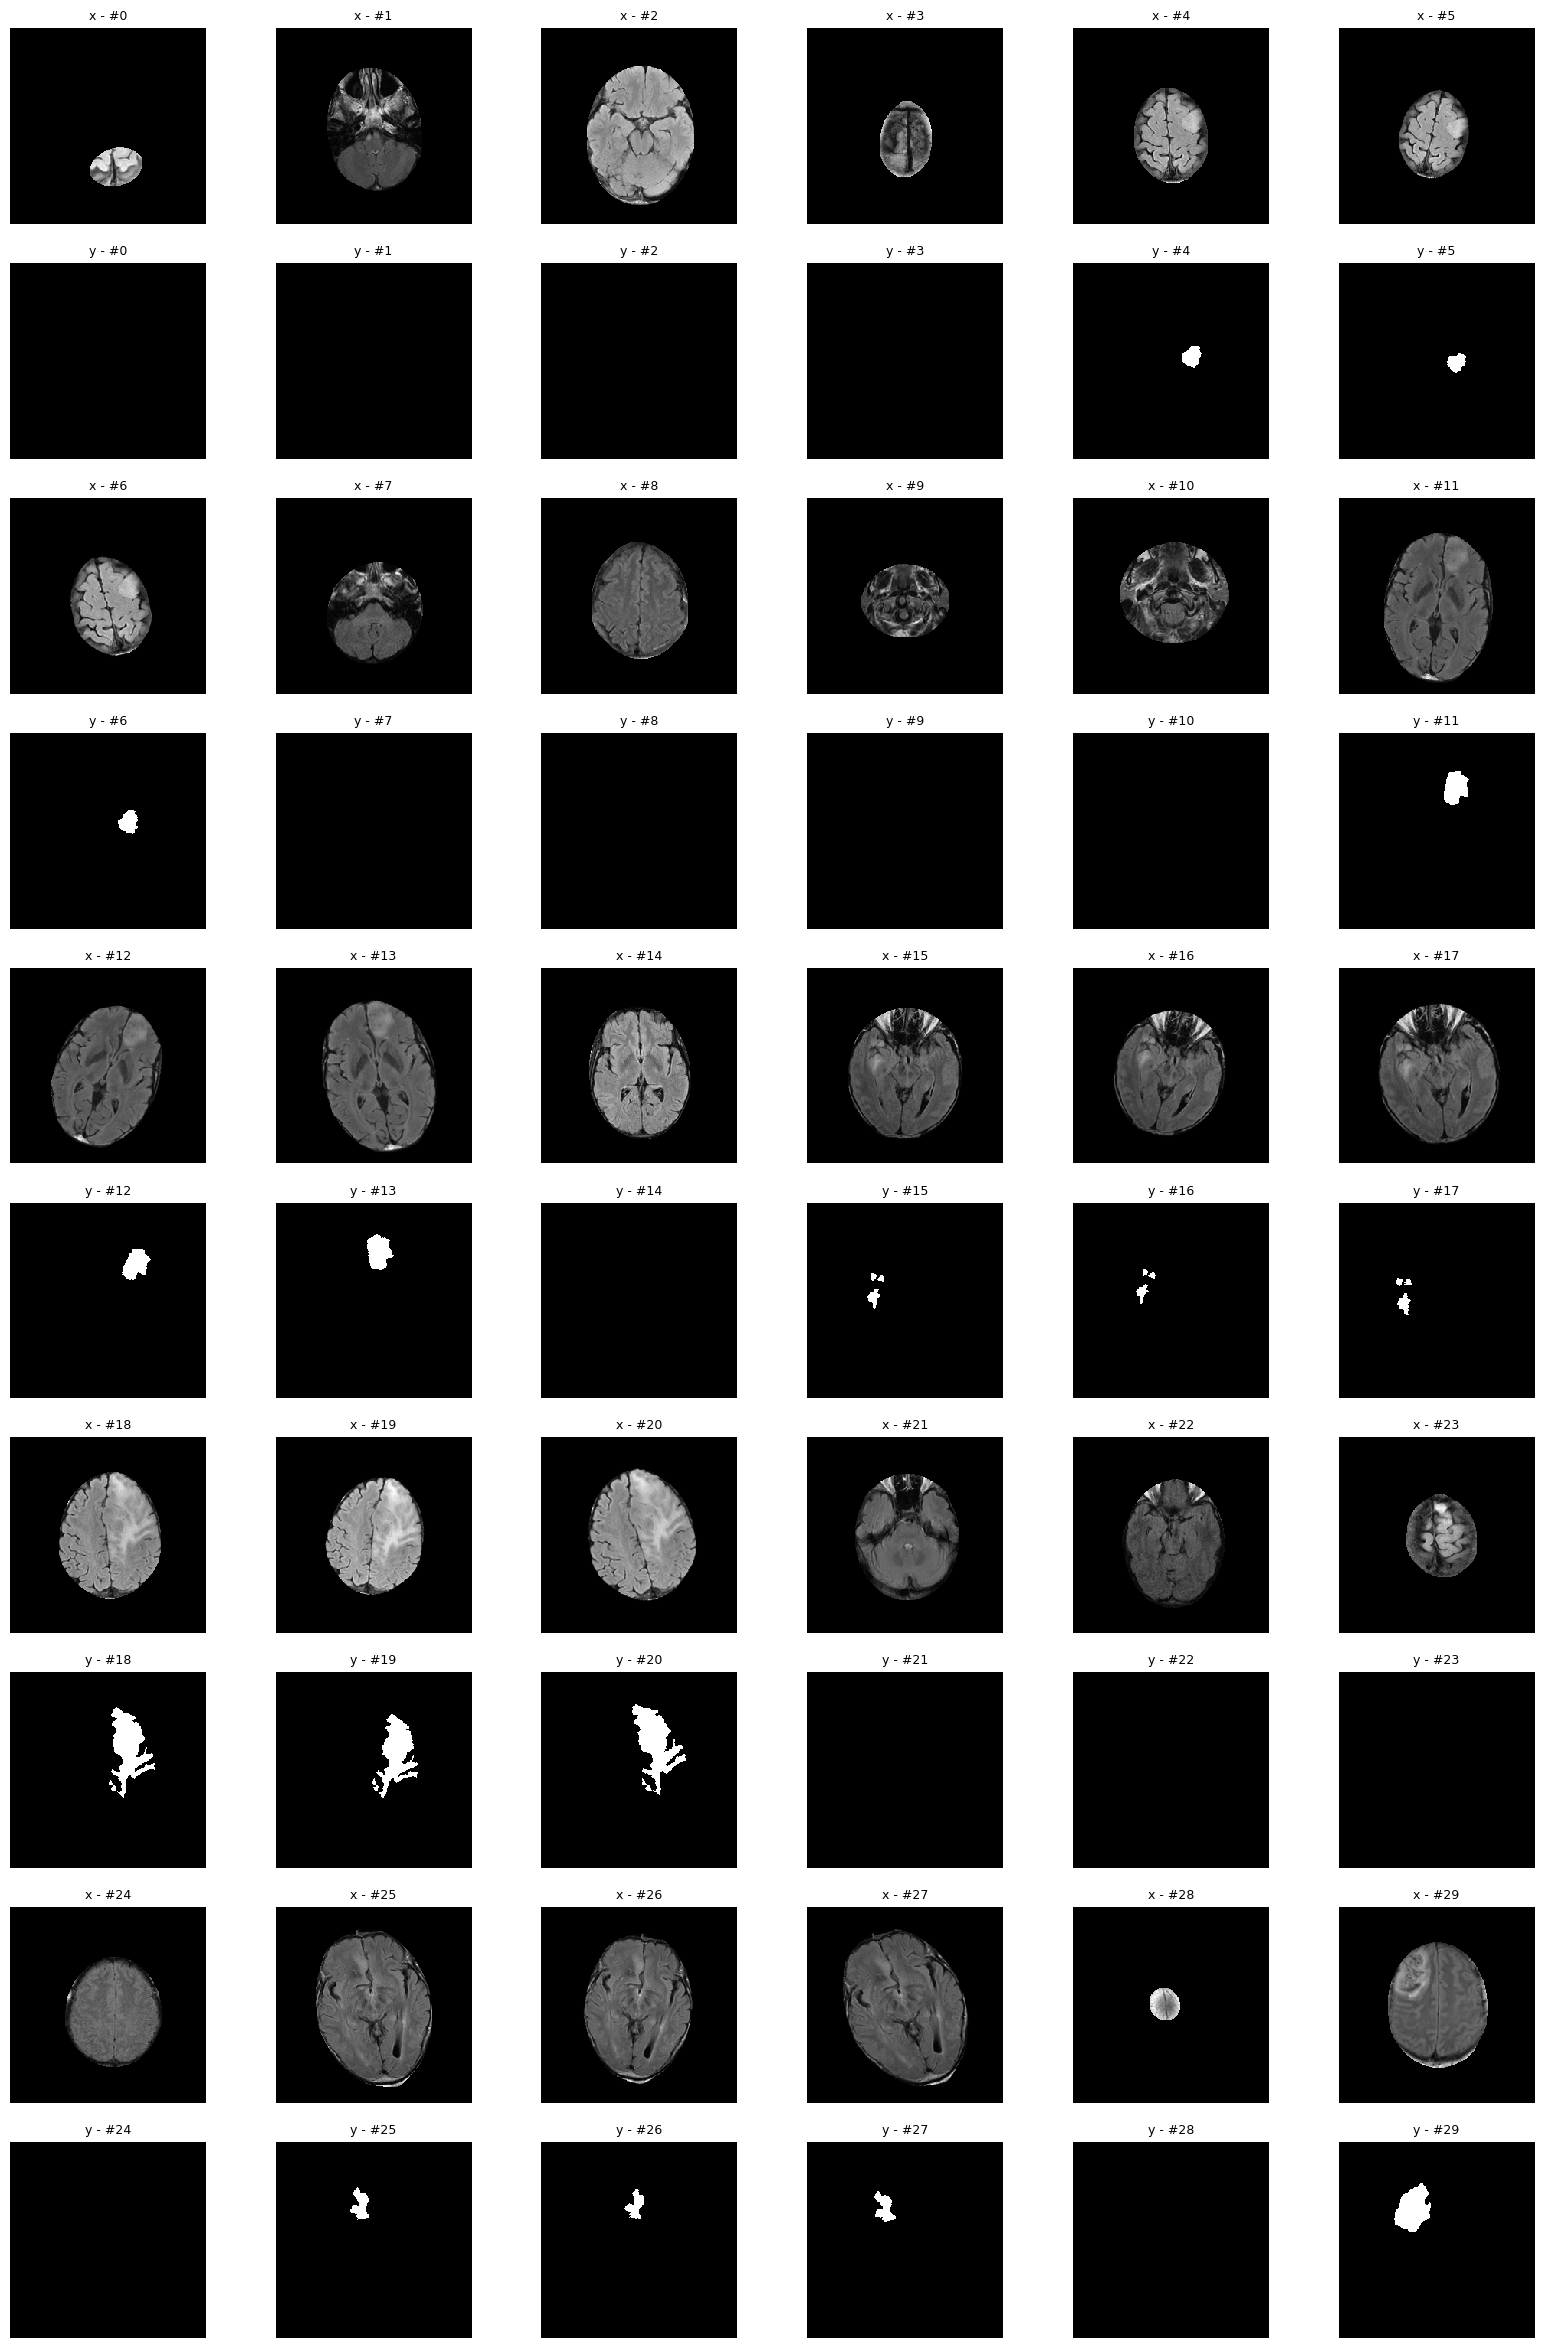

In [58]:
nrep = 5
nrow = 6
fig, axs = plt.subplots(2*nrep,nrow,figsize=(20,6*nrep))
for i in range(nrep):
    for _ in range(nrow): axs[0+2*i,_].imshow(x_train[(_+nrow*i),:,:,1], cmap='gray'), axs[0+2*i,_].axis('off'), axs[0+2*i,_].set_title(f'x - #{(_+nrow*i)}', fontsize=9)
    for _ in range(nrow): axs[1+2*i,_].imshow(y_train[(_+nrow*i),:,:,0], cmap='gray'), axs[1+2*i,_].axis('off'), axs[1+2*i,_].set_title(f'y - #{(_+nrow*i)}',fontsize=9)  
    

In [59]:
#save
with open('data_preprocessed_oversampled_v2.npy', 'wb') as f:
    np.save(f, x_train)
    np.save(f, y_train)
    np.save(f, x_val)
    np.save(f, y_val)
    np.save(f, x_test)
    np.save(f, y_test)

#### U-Net

checking the 3 input channels

x_train.shape:  (2828, 256, 256, 3)


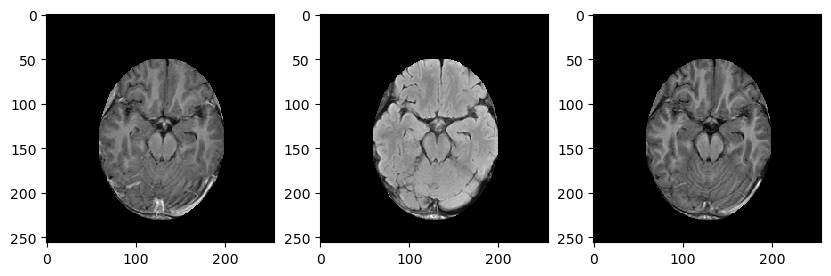

In [42]:
fig, axs = plt.subplots(1,3, figsize=(10,6))
axs[0].imshow(x_train_o[2,:,:,0], cmap='gray')
axs[1].imshow(x_train_o[2,:,:,1], cmap='gray')
axs[2].imshow(x_train_o[2,:,:,2], cmap='gray')
print('x_train.shape: ',x_train.shape)

In [ ]:
#above we can clearly see the 3 different mri sequences of the same skull-stripped slice.

U-Net model builder function:

In [104]:
def unet(batch_norm=False):
    input_size=(256,256,3)
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), padding='same')(inputs)
    if batch_norm:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Activation('relu')(conv1)

    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    if batch_norm:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Activation('relu')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    if batch_norm:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Activation('relu')(conv2)

    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    if batch_norm:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Activation('relu')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    if batch_norm:
        conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Activation('relu')(conv3)

    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    if batch_norm:
        conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Activation('relu')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
    if batch_norm:
        conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Activation('relu')(conv4)

    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    if batch_norm:
        conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Activation('relu')(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    if batch_norm:
        conv5 = BatchNormalization(axis=3)(conv5)
    conv5 = Activation('relu')(conv5)

    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    if batch_norm:
        conv5 = BatchNormalization(axis=3)(conv5)
    conv5 = Activation('relu')(conv5)

    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)

    conv6 = Conv2D(256, (3, 3), padding='same')(up6)
    if batch_norm:
        conv6 = BatchNormalization(axis=3)(conv6)
    conv6 = Activation('relu')(conv6)

    conv6 = Conv2D(256, (3, 3), padding='same')(conv6)
    if batch_norm:
        conv6 = BatchNormalization(axis=3)(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)

    conv7 = Conv2D(128, (3, 3), padding='same')(up7)
    if batch_norm:
        conv7 = BatchNormalization(axis=3)(conv7)
    conv7 = Activation('relu')(conv7)

    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    if batch_norm:
        conv7 = BatchNormalization(axis=3)(conv7)
    conv7 = Activation('relu')(conv7)

    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)

    conv8 = Conv2D(64, (3, 3), padding='same')(up8)
    if batch_norm:
        conv8 = BatchNormalization(axis=3)(conv8)
    conv8 = Activation('relu')(conv8)

    conv8 = Conv2D(64, (3, 3), padding='same')(conv8)
    if batch_norm:
        conv8 = BatchNormalization(axis=3)(conv8)
    conv8 = Activation('relu')(conv8)

    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)

    conv9 = Conv2D(32, (3, 3), padding='same')(up9)
    if batch_norm:
        conv9 = BatchNormalization(axis=3)(conv9)
    conv9 = Activation('relu')(conv9)

    conv9 = Conv2D(32, (3, 3), padding='same')(conv9)
    if batch_norm:
        conv9 = BatchNormalization(axis=3)(conv9)
    conv9 = Activation('relu')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


In [105]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
#global standardization 
mean = np.mean(x_train)
std = np.std(x_train)
x_train-= mean
x_train /= std

x_val -= mean  #using training mean and std also for val data standardization
x_val /= std

x_test -= mean  #using training mean and std also for test data standardization
x_test /= std

In [109]:
#using pre-trained U-Net for predictions of FLAIR segmentation
weights_path = './weights_64.h5'

def predict(data):
    # load model with weights 
    model = unet(batch_norm=False)
    model.load_weights(weights_path)

    # make predictions
    imgs_mask_pred = model.predict(data, verbose=1)

    return imgs_mask_pred

imgs_mask_pred_val = predict(x_val)
imgs_mask_pred_test = predict(x_test)


367/367 [==============================] - 66s 181ms/sample


In [113]:
#val accuracy
y_pred = imgs_mask_pred_val.copy()
thresh = 0.5
y_pred[y_pred<=thresh] = 0
y_pred[y_pred>thresh] = 1

print(dice_coefficient(y_pred, y_val))
print(dice_coeff(y_val, y_pred))

0.7119998572136129
tf.Tensor(0.71203196, shape=(), dtype=float32)


In [114]:
#val accuracy
y_pred = imgs_mask_pred_test.copy()
thresh = 0.5
y_pred[y_pred<=thresh] = 0
y_pred[y_pred>thresh] = 1

print(dice_coefficient(y_pred, y_test))
print(dice_coeff(y_val, y_pred))

0.7411939476927758


InvalidArgumentError: Incompatible shapes: [43188224] vs. [24051712] [Op:Mul] name: mul/

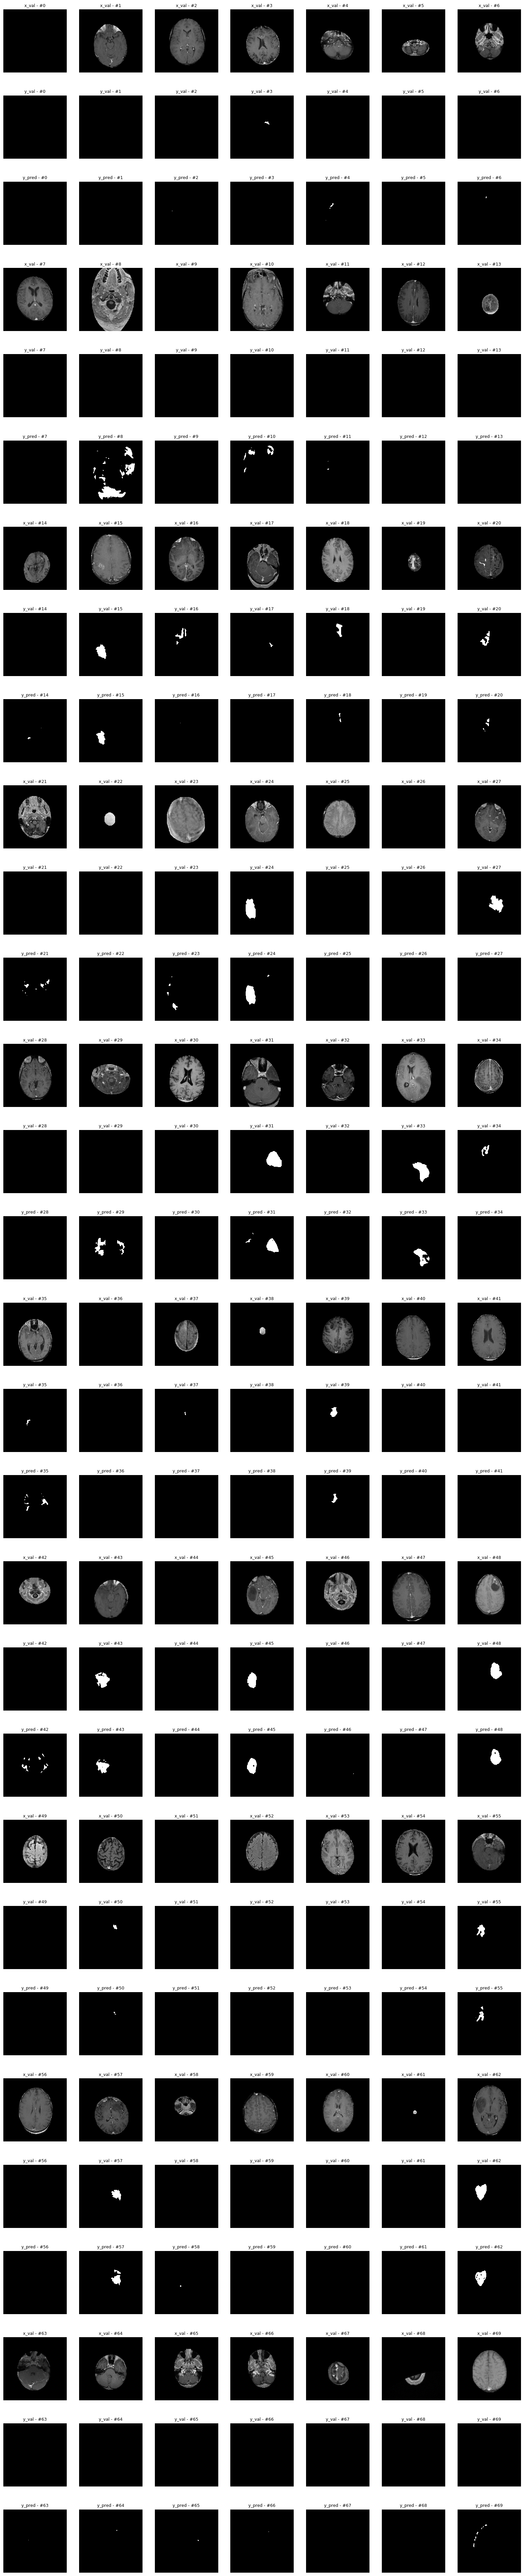

In [ ]:
#plotting y_val
nrow = 7
nrep = 10
offset = 0
fig, axs = plt.subplots(3*nrep,nrow,figsize=(20,10*nrep))
for i in range(nrep):
    for _ in range(nrow): axs[0+3*i,_].imshow(x_val[(_+nrow*i)+offset,:,:,0], cmap='gray'), axs[0+3*i,_].axis('off'), axs[0+3*i,_].set_title(f'x_val - #{(_+nrow*i)+offset}', fontsize=9)
    for _ in range(nrow): axs[1+3*i,_].imshow(y_val[(_+nrow*i)+offset,:,:,0], cmap='gray'), axs[1+3*i,_].axis('off'), axs[1+3*i,_].set_title(f'y_val - #{(_+nrow*i)+offset}',fontsize=9)
    for _ in range(nrow): axs[2+3*i,_].imshow(y_pred[(_+nrow*i)+offset,:,:,0], cmap='gray'), axs[2+3*i,_].axis('off'), axs[2+3*i,_].set_title(f'y_pred - #{(_+nrow*i)+offset}',fontsize=9)
    
    

In [178]:
#TEST accuracy
y_pred = imgs_mask_pred_test.copy()
thresh = 0.5
y_pred[y_pred<=thresh] = 0
y_pred[y_pred>thresh] = 1

print(dice_coefficient(y_pred, y_test))
print(dice_coeff(y_test, y_pred))

0.7310016177129827
tf.Tensor(0.7310453, shape=(), dtype=float32)


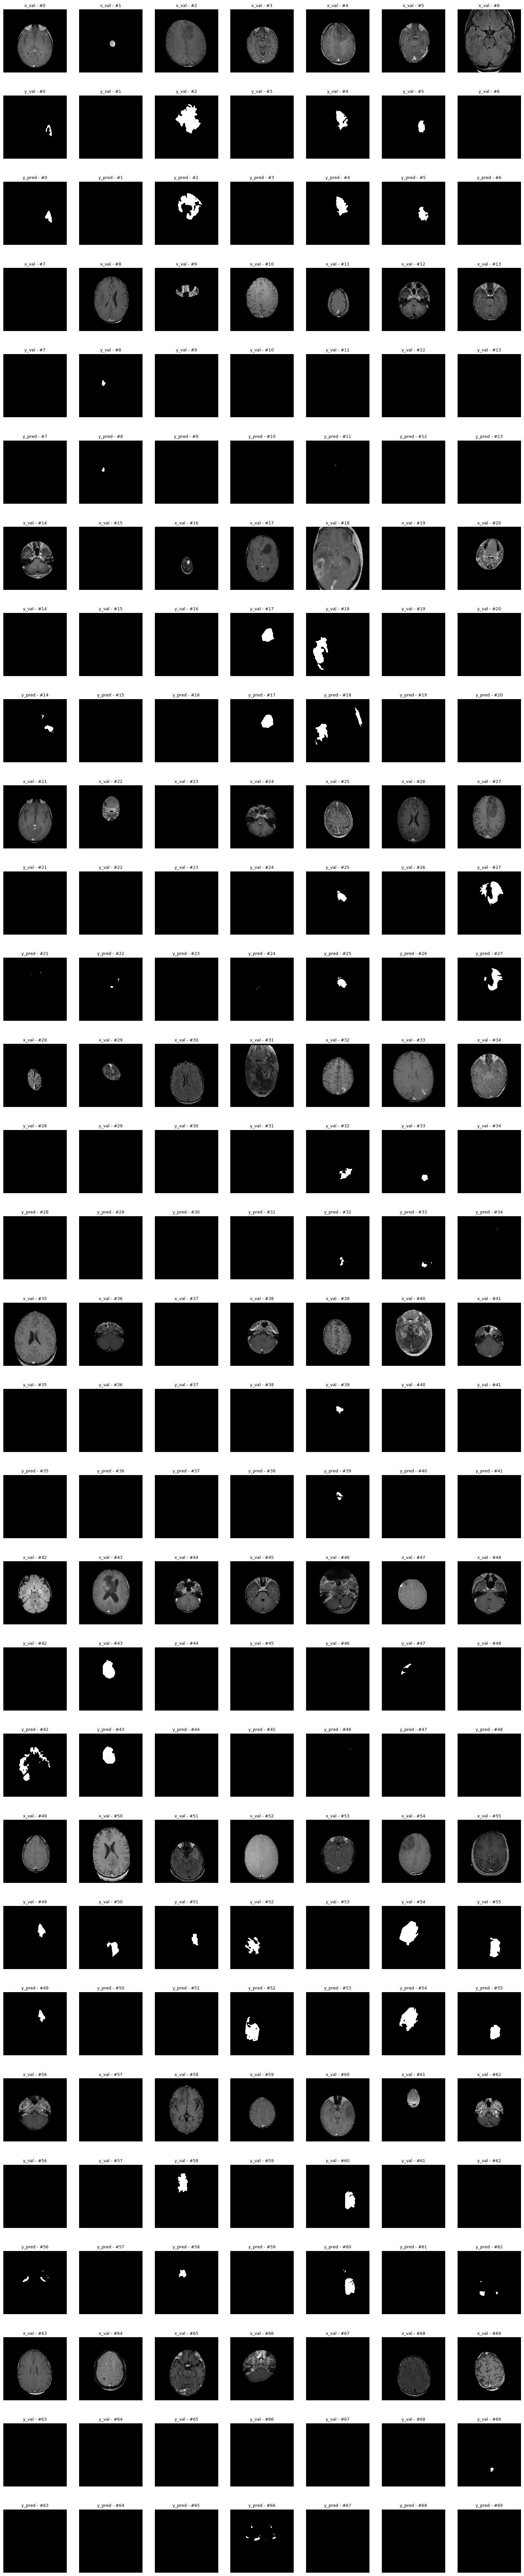

In [180]:
#plotting y_test
nrow = 7
nrep = 10
offset = 0
fig, axs = plt.subplots(3*nrep,nrow,figsize=(20,10*nrep))
for i in range(nrep):
    for _ in range(nrow): axs[0+3*i,_].imshow(x_test[(_+nrow*i)+offset,:,:,0], cmap='gray'), axs[0+3*i,_].axis('off'), axs[0+3*i,_].set_title(f'x_val - #{(_+nrow*i)+offset}', fontsize=9)
    for _ in range(nrow): axs[1+3*i,_].imshow(y_test[(_+nrow*i)+offset,:,:,0], cmap='gray'), axs[1+3*i,_].axis('off'), axs[1+3*i,_].set_title(f'y_val - #{(_+nrow*i)+offset}',fontsize=9)
    for _ in range(nrow): axs[2+3*i,_].imshow(y_pred[(_+nrow*i)+offset,:,:,0], cmap='gray'), axs[2+3*i,_].axis('off'), axs[2+3*i,_].set_title(f'y_pred - #{(_+nrow*i)+offset}',fontsize=9)
    
    

In [ ]:
#despite our efforst we were not able to replicate the restults obtained by ........

In [ ]:
len(imgs_mask_pred_val)

708

In [57]:
y_pred = np.reshape(imgs_mask_pred_val, (708,256,256))

In [111]:
def dice_coefficient(prediction, ground_truth):
    prediction = np.round(prediction).astype(int)
    ground_truth = np.round(ground_truth).astype(int)
    np.sum(prediction[ground_truth == 1])
    return (
        np.sum(prediction[ground_truth == 1])
        * 2.0
        / (np.sum(prediction) + np.sum(ground_truth))
    )

def dice_coeff(ytrue, ypred, smooth=100):
    ytrue_flat = K.flatten(ytrue)
    ypred_flat = K.flatten(ypred)
    intersection = K.sum(ytrue_flat * ypred_flat)
    total_area = K.sum(ytrue_flat) + K.sum(ypred_flat)
    return (2*intersection + smooth)/(total_area + smooth)

def dice_coeff_loss(ytrue,ypred, smooth=100):
    return 1-dice_coeff(ytrue, ypred, smooth)

def iou_coeff(ytrue, ypred, smooth=100):
    intersection = K.sum(ytrue * ypred)
    union = K.sum(ytrue + ypred) - intersection
    return (intersection + smooth)/(union + smooth)

In [63]:
def reshape(x):
    return np.reshape(x, (256,256))

In [68]:
y_val.shape

(708, 256, 256, 1)

In [ ]:
for _ in range(nrow): axs[1+3*i,_].imshow(reshape(y_val[(_+nrow*i)+offset), cmap='gray'), axs[1+3*i,_].axis('off'), axs[1+3*i,_].set_title(f'y_val - #{(_+nrow*i)+offset}',fontsize=9)

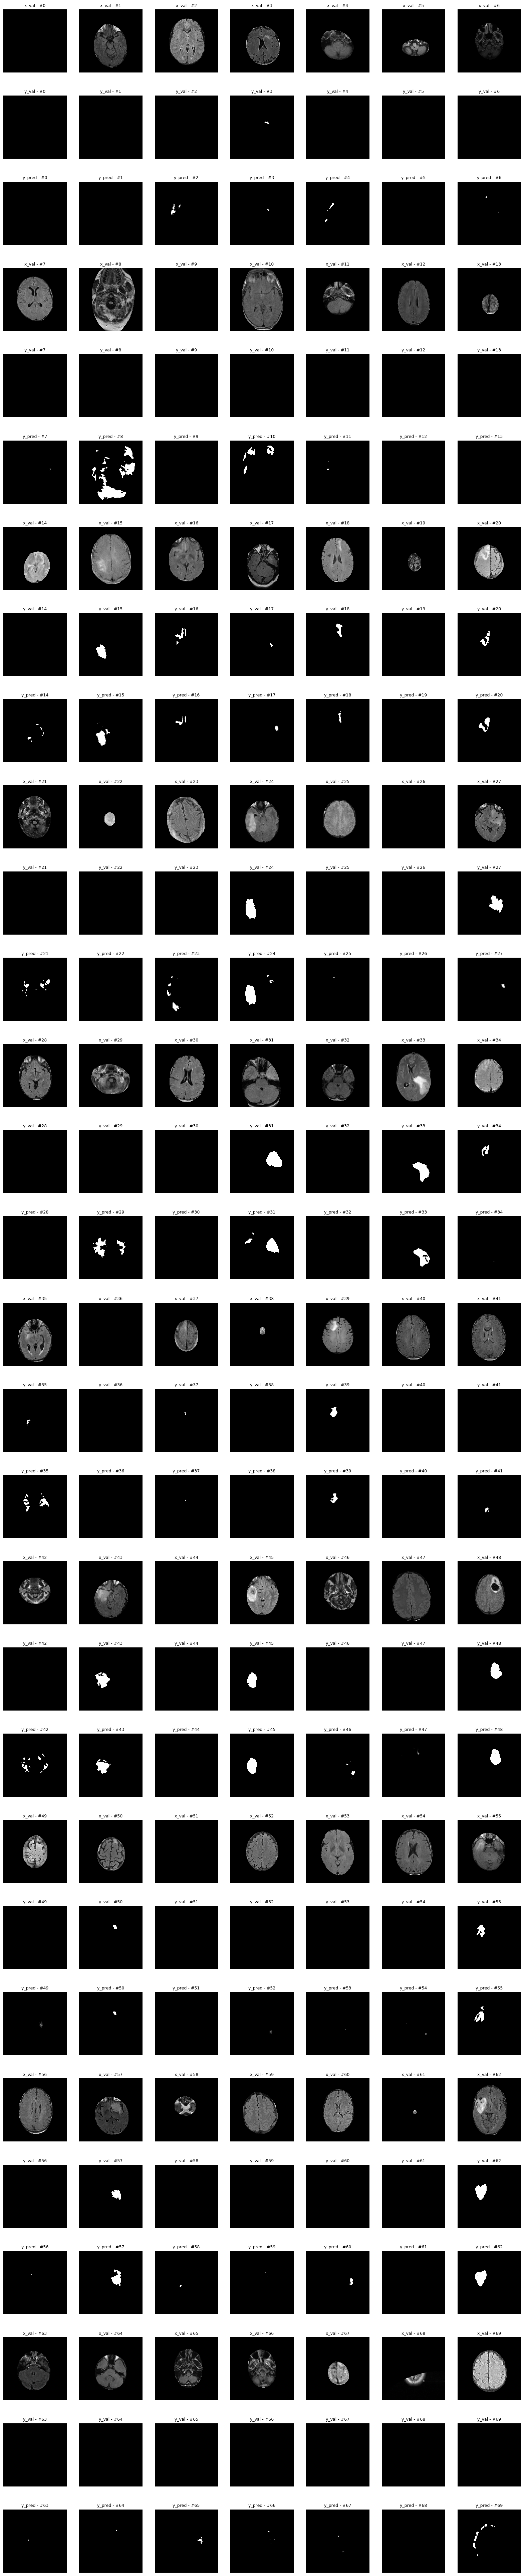

In [70]:
nrow = 7
nrep = 10
offset = 0
fig, axs = plt.subplots(3*nrep,nrow,figsize=(20,10*nrep))
for i in range(nrep):
    for _ in range(nrow): axs[0+3*i,_].imshow(x_val[(_+nrow*i)+offset,:,:,1], cmap='gray'), axs[0+3*i,_].axis('off'), axs[0+3*i,_].set_title(f'x_val - #{(_+nrow*i)+offset}', fontsize=9)
    for _ in range(nrow): axs[1+3*i,_].imshow(reshape(y_val[(_+nrow*i)+offset]), cmap='gray'), axs[1+3*i,_].axis('off'), axs[1+3*i,_].set_title(f'y_val - #{(_+nrow*i)+offset}',fontsize=9)
    for _ in range(nrow): axs[2+3*i,_].imshow(y_pred[(_+nrow*i)+offset], cmap='gray'), axs[2+3*i,_].axis('off'), axs[2+3*i,_].set_title(f'y_pred - #{(_+nrow*i)+offset}',fontsize=9)
    
    

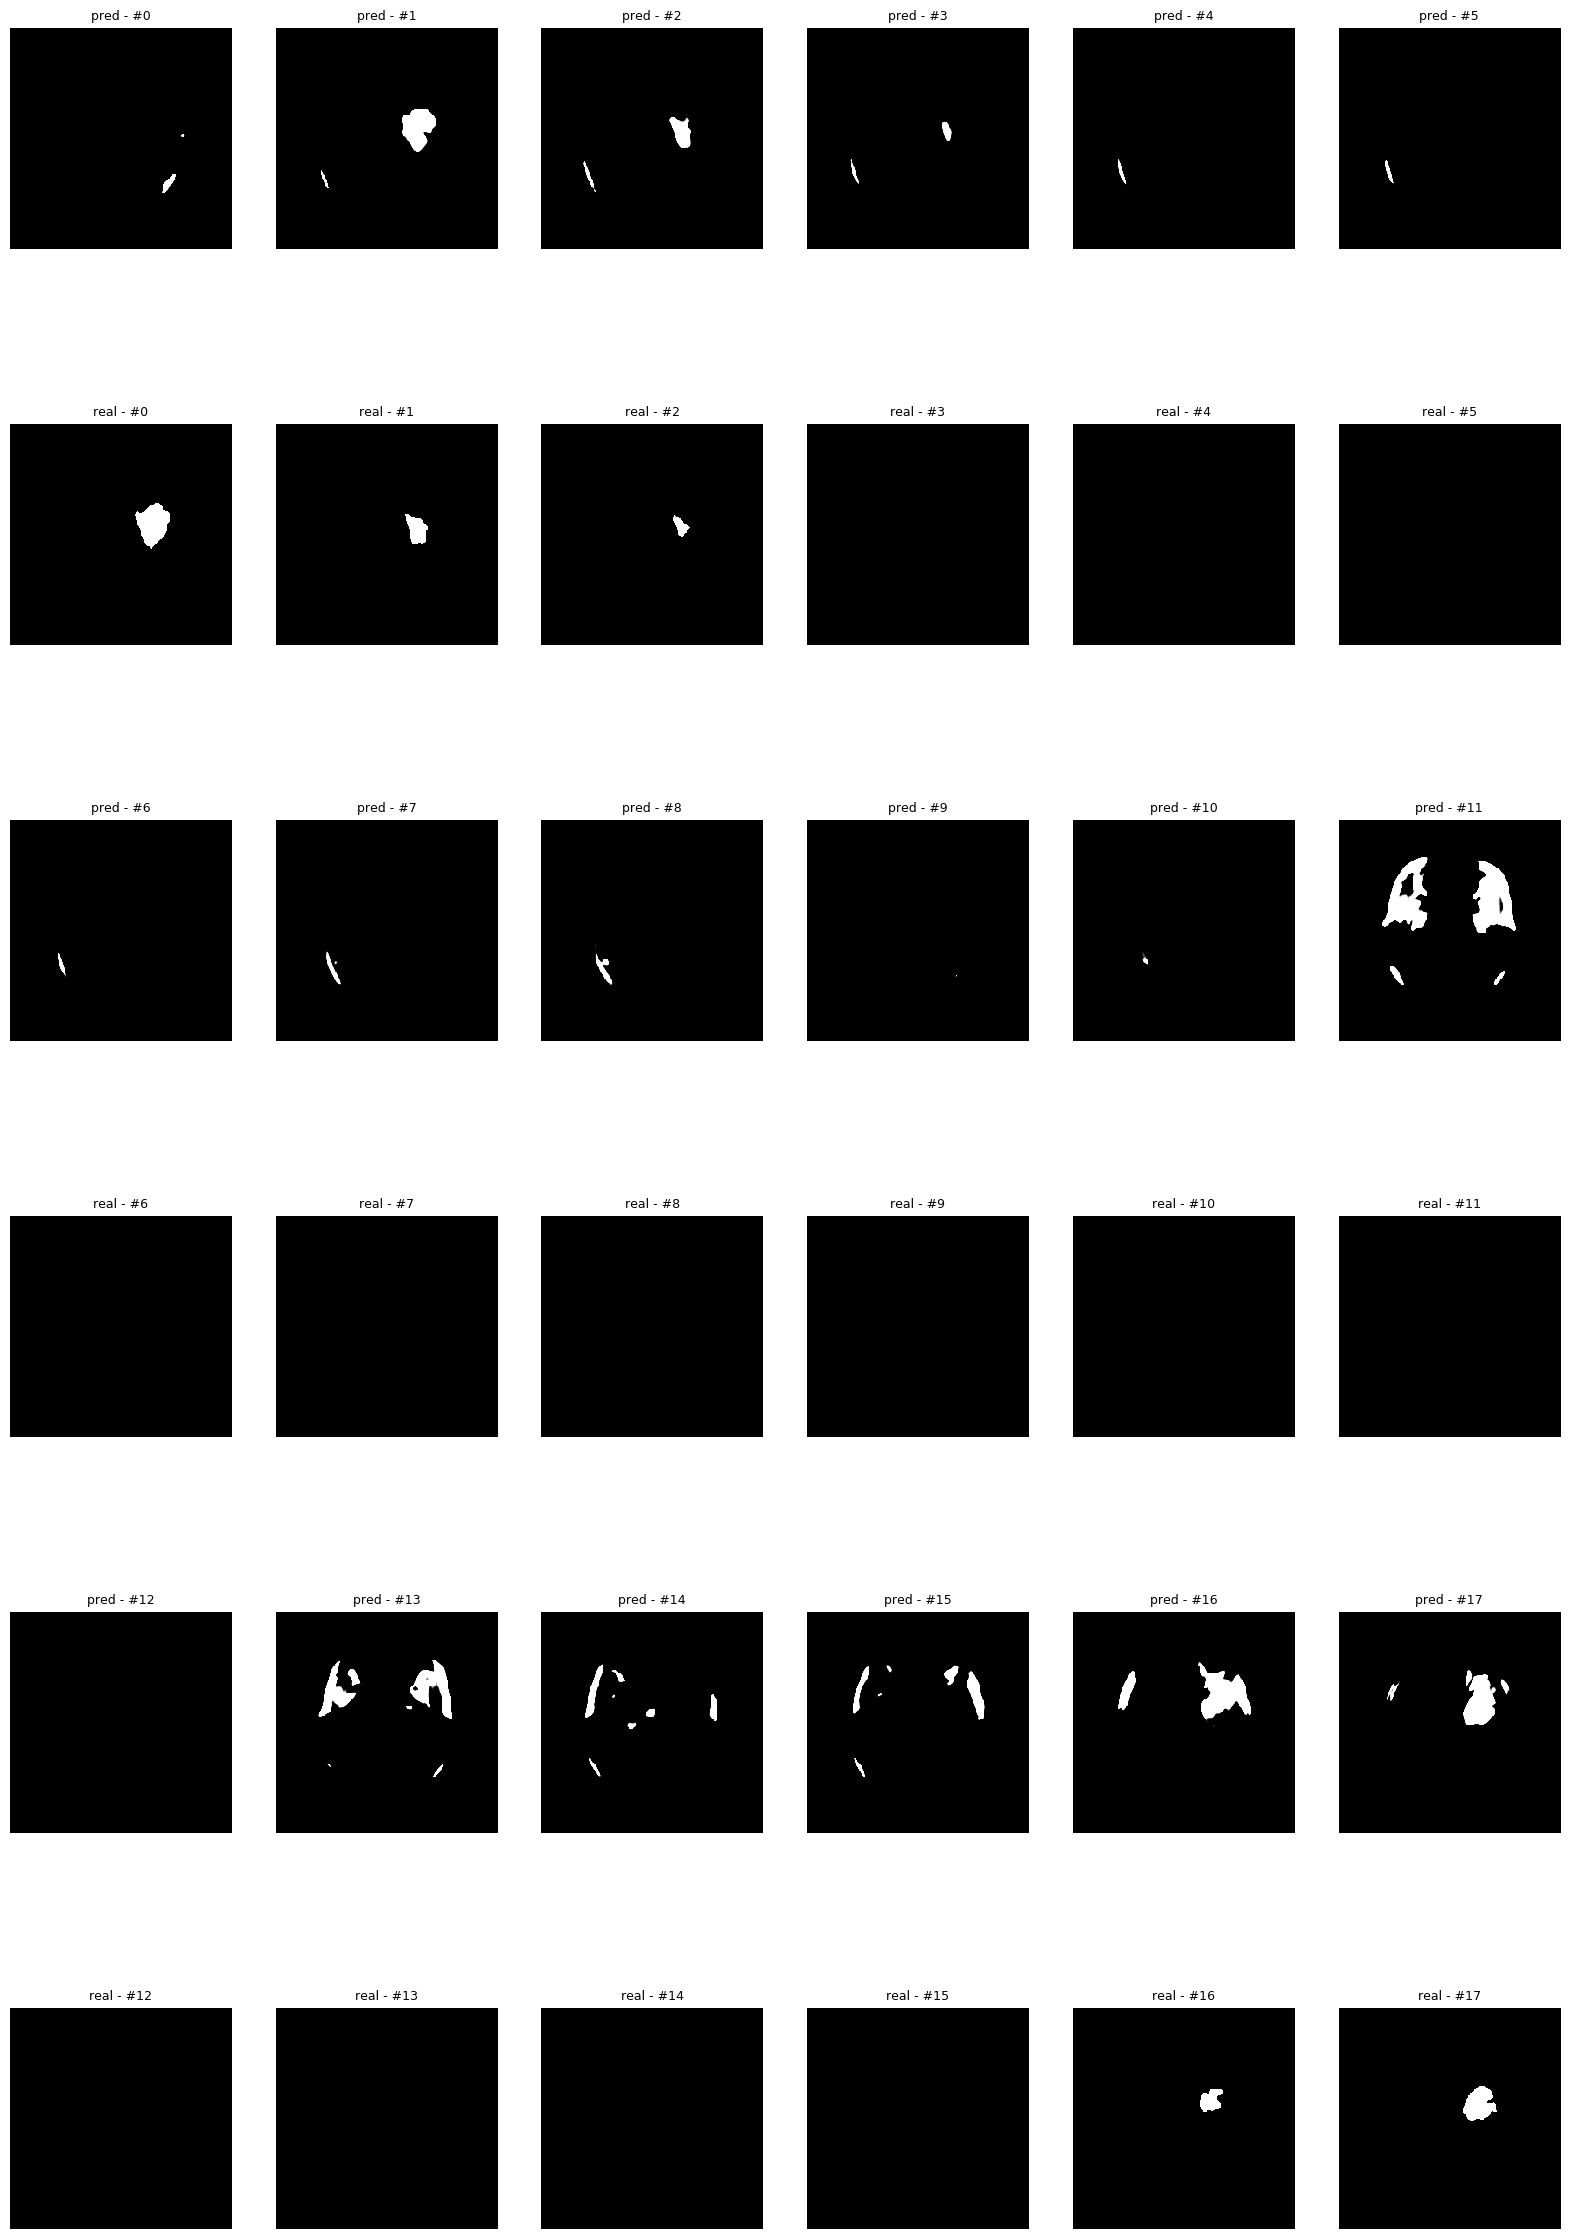

In [147]:
nrep = 3
nrow = 6
fig, axs = plt.subplots(2*nrep,nrow,figsize=(20,10*nrep))
for i in range(nrep):
    for _ in range(nrow): axs[0+2*i,_].imshow(imgs_mask_pred_pid_7884[(_+nrow*i),:,:,0], cmap='gray'), axs[0+2*i,_].axis('off'), axs[0+2*i,_].set_title(f'pred - #{(_+nrow*i)}', fontsize=9)
    for _ in range(nrow): axs[1+2*i,_].imshow(reshape(y_pid_7884[(_+nrow*i)]), cmap='gray'), axs[1+2*i,_].axis('off'), axs[1+2*i,_].set_title(f'real - #{(_+nrow*i)}',fontsize=9)  

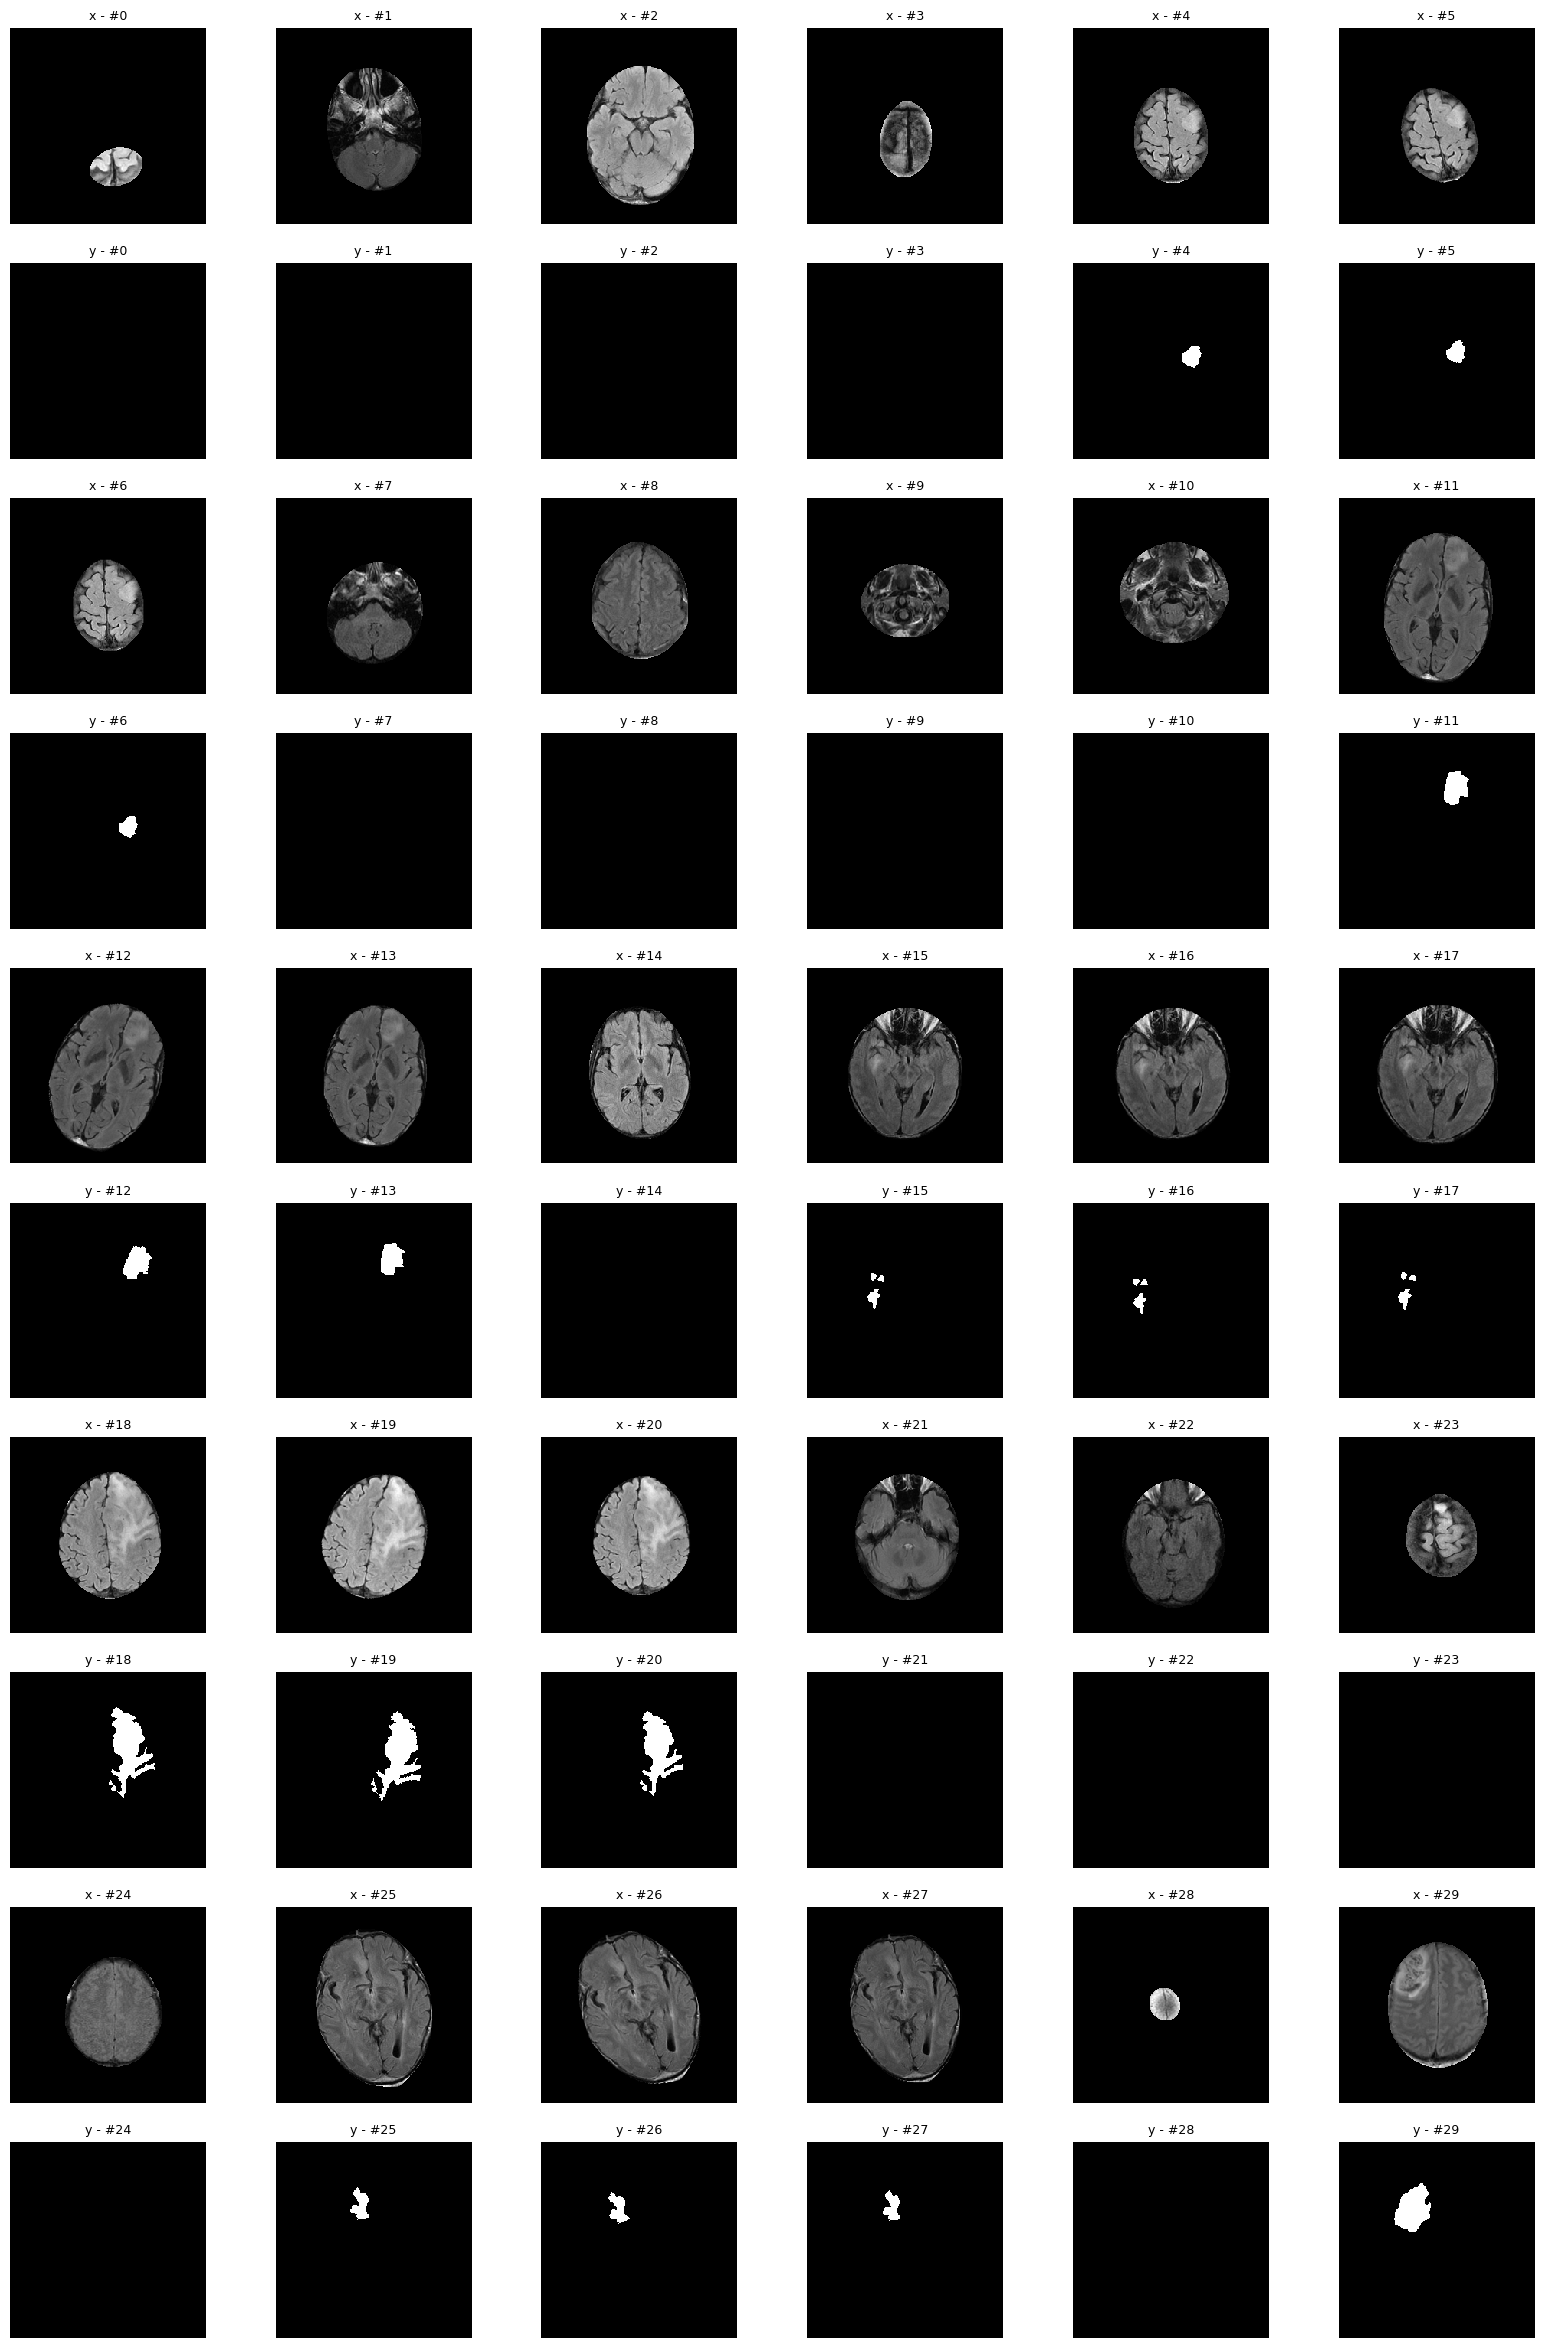

In [37]:
nrep = 5
nrow = 6
fig, axs = plt.subplots(2*nrep,nrow,figsize=(20,6*nrep))
for i in range(nrep):
    for _ in range(nrow): axs[0+2*i,_].imshow(x_train[(_+nrow*i),:,:,1], cmap='gray'), axs[0+2*i,_].axis('off'), axs[0+2*i,_].set_title(f'x - #{(_+nrow*i)}', fontsize=9)
    for _ in range(nrow): axs[1+2*i,_].imshow(y_train[(_+nrow*i),:,:,0], cmap='gray'), axs[1+2*i,_].axis('off'), axs[1+2*i,_].set_title(f'y - #{(_+nrow*i)}',fontsize=9)  
    

In [90]:
2*a

array([18,  6,  0, 14, 16,  6,  8, 14, 10,  8])

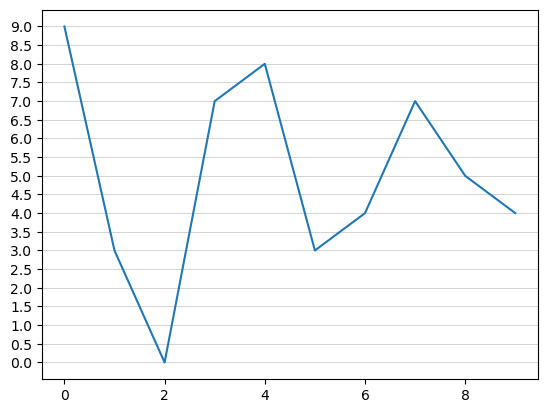

In [102]:
plt.plot(a)
#plt.ylim([0,10])
plt.locator_params(axis='y',nbins=20)
plt.grid(axis = 'y', linewidth = 0.4)
